# Support vector machines

In [2]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer

## Data pre-processing

In [3]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv ('test_features.csv')

 ### Histogram of the output labels 

We should check for class imbalance.

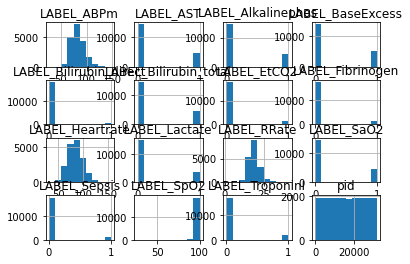

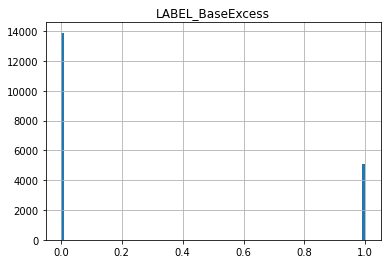

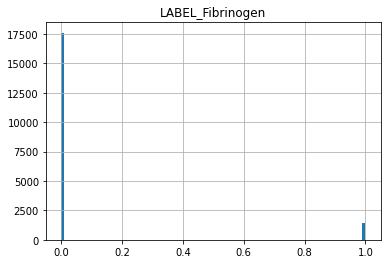

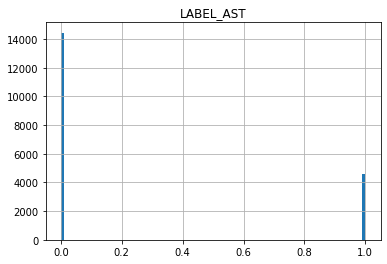

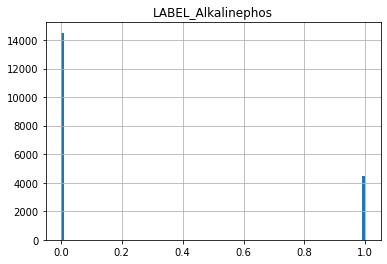

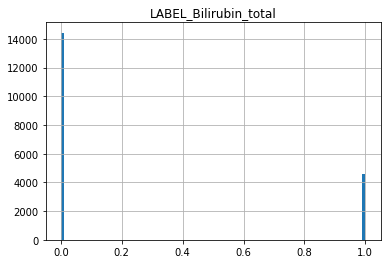

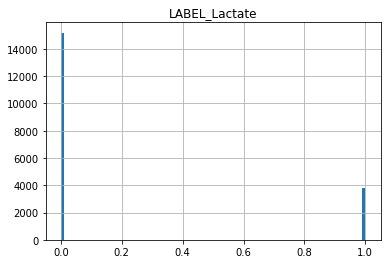

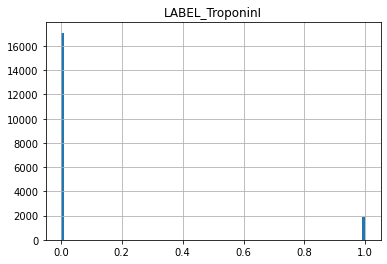

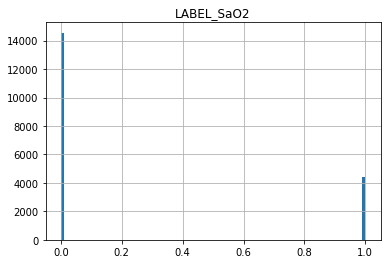

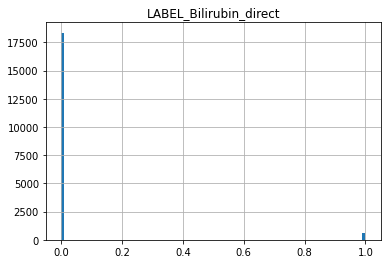

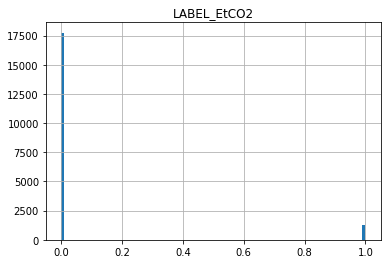

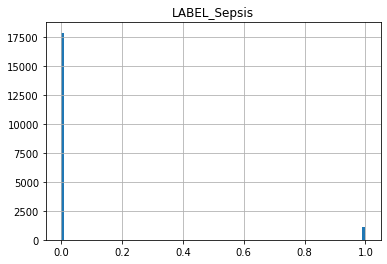

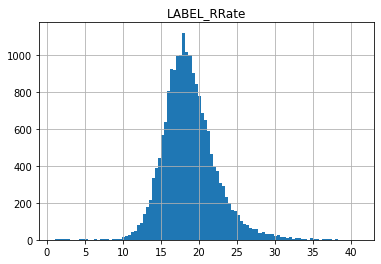

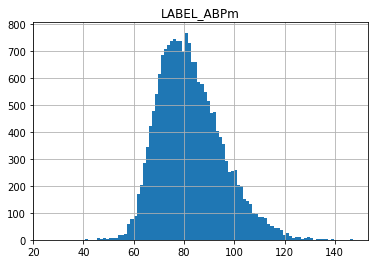

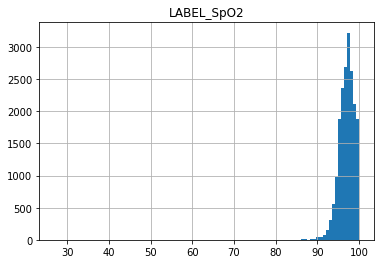

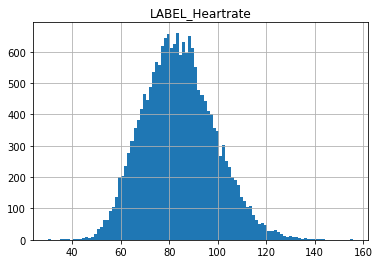

In [3]:
df_train_labels.hist()

with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
    for i in list(df_train_labels)[1:]:
        df_train_labels.hist(column = i, bins = 100)
        export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Train Data pre-processing

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      1     1   15.0   10.0   12.5    1.0      0.2  21.0   3.3   0.0  ...   
max  31658   315  100.0  100.0  250.0  268.0     31.0  42.0  23.8  50.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          12.0   20.0              0.01      66.0   9.4       23.0   
max        3833.0  100.0             21.20     141.0  63.4      191.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   21.0  6.82  
max             46.5     440.00  287.0  7.78  

[2 rows x 37 columns]


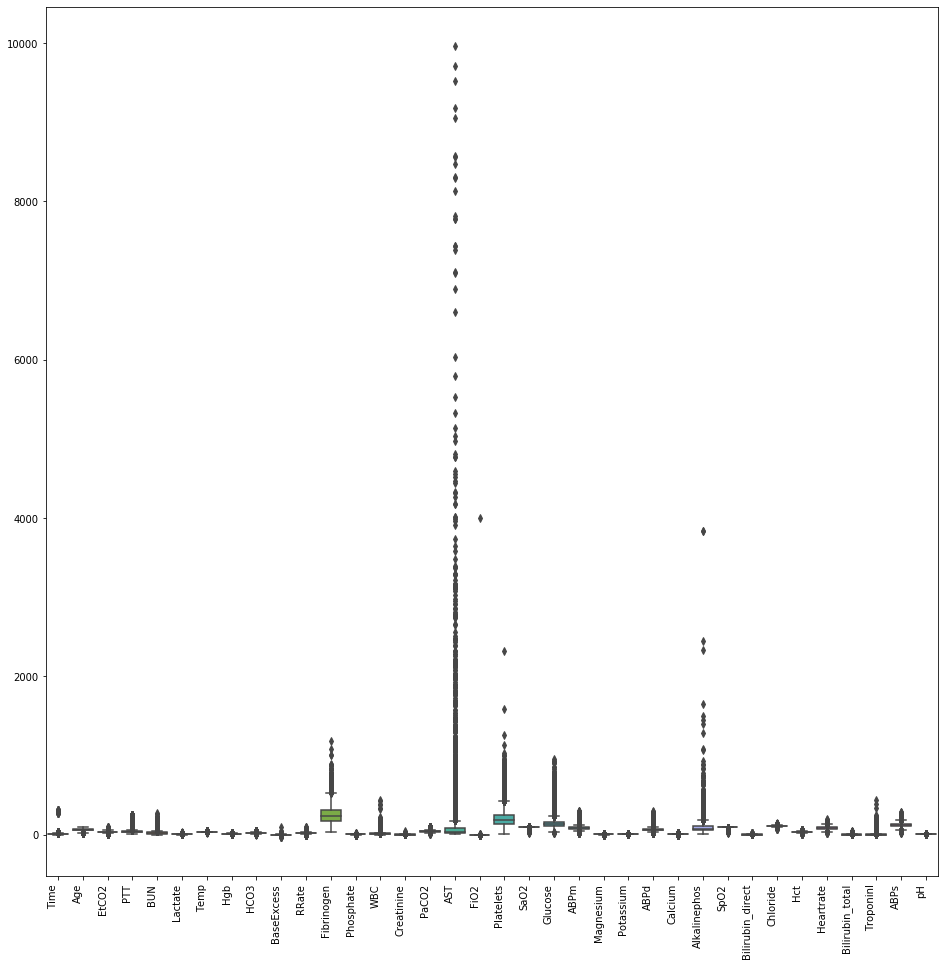

In [4]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

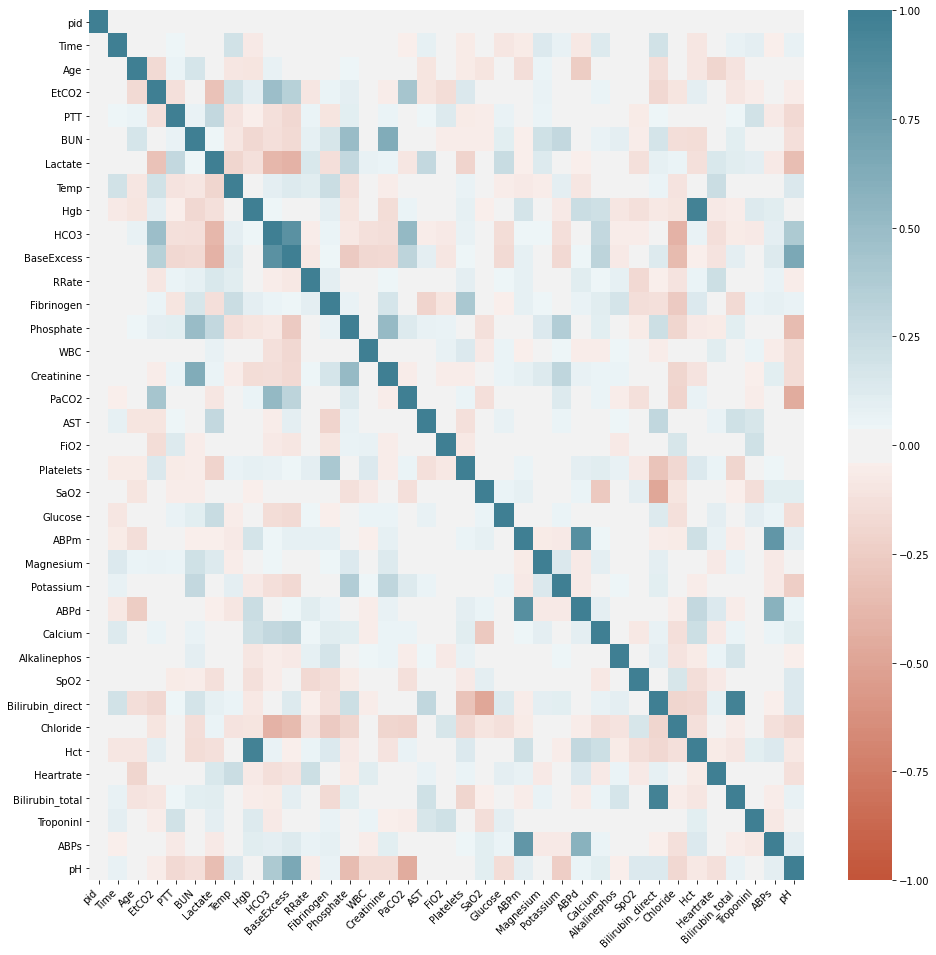

In [24]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

Percentage of missing values:
pid                 0.000000
Time                0.000000
Age                 0.000000
EtCO2               0.957081
PTT                 0.954817
BUN                 0.911797
Lactate             0.952812
Temp                0.644139
Hgb                 0.902189
HCO3                0.944902
BaseExcess          0.912753
RRate               0.176165
Fibrinogen          0.989063
Phosphate           0.949153
WBC                 0.916281
Creatinine          0.921944
PaCO2               0.907682
AST                 0.974726
FiO2                0.883294
Platelets           0.920878
SaO2                0.942906
Glucose             0.793647
ABPm                0.140612
Magnesium           0.923125
Potassium           0.875437
ABPd                0.331324
Calcium             0.921778
Alkalinephos        0.974958
SpO2                0.143669
Bilirubin_direct    0.996846
Chloride            0.938944
Hct                 0.880245
Heartrate           0.122015
Bilirubin_tot

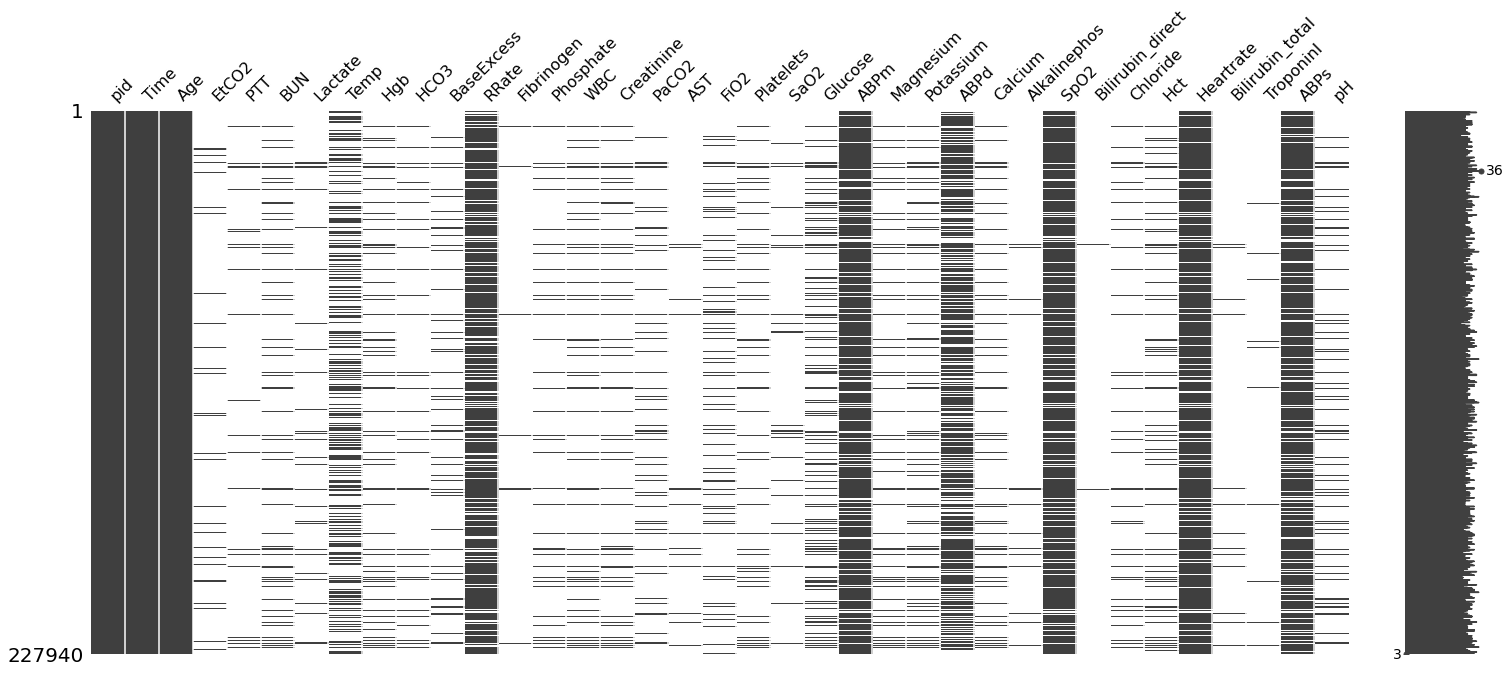

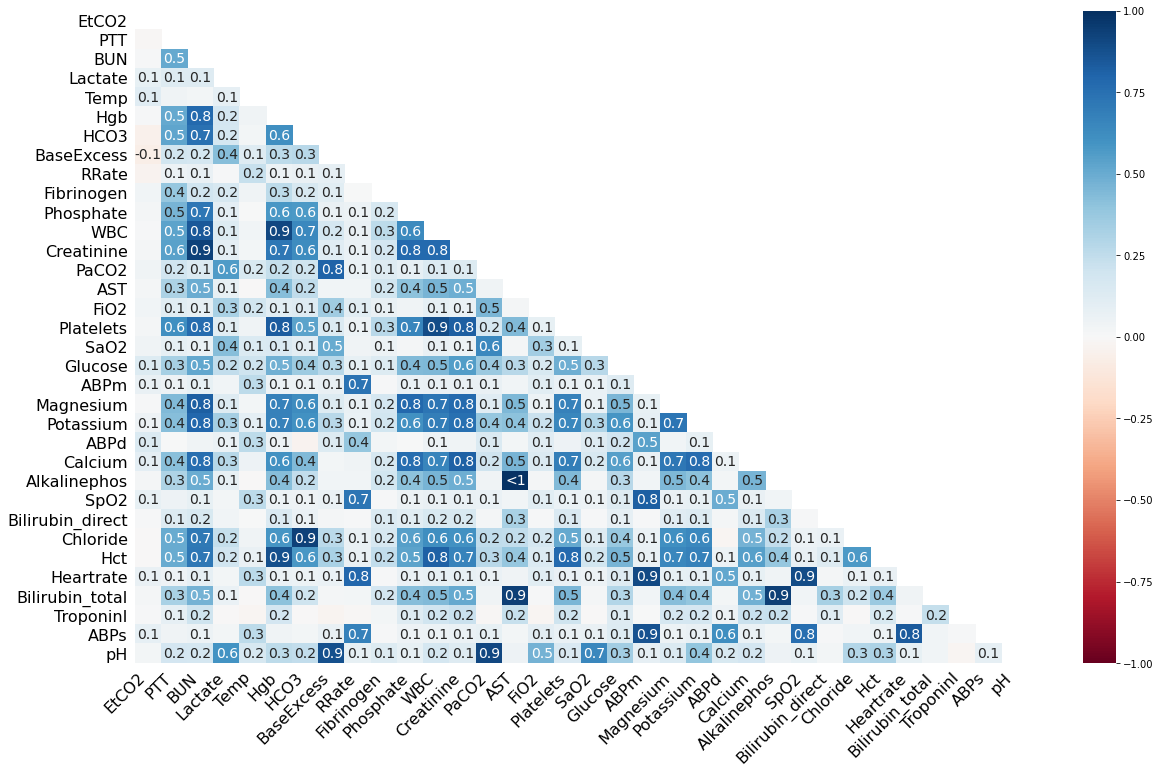

In [14]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

### Train data pre-processing

In [10]:
# Patient by patient pre-processing for imputation and feature generation

# get all pids, to impute and pre-process individually
train_pids = df_train_features['pid'].unique()

for pid in train_pids:
    # dataframe for this pid
    df = df_train_features.loc[df_train_features['pid'] == pid]
    
    imp = SimpleImputer()
    train_imputed = imp.fit_transform(df)
    
    #df_imp = pd.DataFrame(data=train_imputed, columns = df_train_features.columns)
    
    print(np.shape(train_imputed))
    print(np.shape(df))
    break


(12, 27)
(12, 37)


In [5]:
# THIS STEP REMOVES ALL NAN !!!

# aggregate data for each pid
# GROUPBY REARRANGES THE ROWS, WE HAVE TO DO THE SAME FOR THE LABELS
df_train_aggregate_features = df_train_features.groupby('pid').agg('median')

# print(df_train_aggregate_features)

In [6]:
# remove time from data frame 
df_train_agg_features = df_train_aggregate_features.drop(['Time'], axis = 1)
# print(df_train_agg_features)

In [7]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors=12)
df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)
#print(df_train_agg_imputed_features)

In [8]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [49]:
# REARRANGE THE LABELS, TO MATCH THE REARRANGED FEATURES
df_train_labels_sorted = df_train_labels.sort_values(by = 'pid')
# print(df_train_labels_sorted)

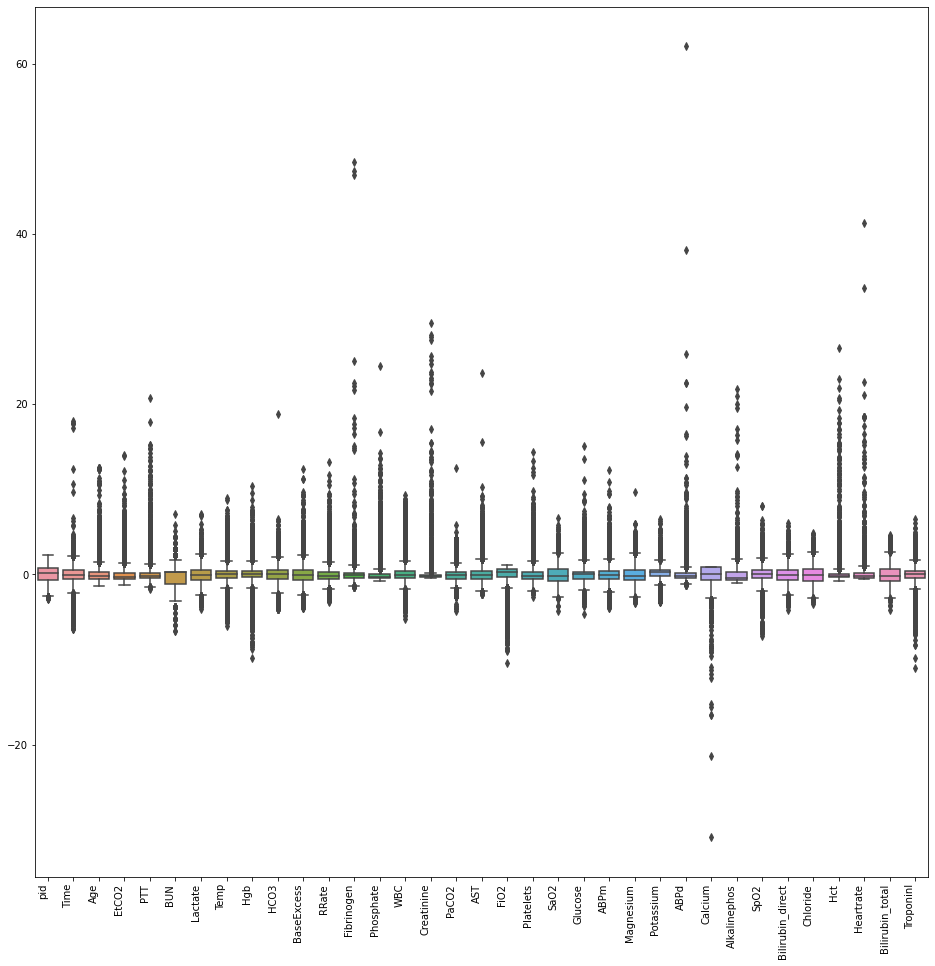

In [50]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [51]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
22    1.0
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    1.0
34    1.0
dtype: float64

### Test Data pre-processing

In [52]:
# data inspection: 
#############################################
# range of the provided data?
print(df_test_features.agg([min, max]))

# how much missing data? 
print("number of missing values:")
print(df_test_features.isnull().sum(axis=0))

       pid  Time    Age  EtCO2    PTT    BUN  Lactate  Temp   Hgb  HCO3  ...  \
min      0     1   16.0   10.0   18.1    1.0      0.3  27.0   2.3   0.0  ...   
max  31655   293  100.0  100.0  249.9  205.0     23.3  42.0  23.8  49.0  ...   

     Alkalinephos   SpO2  Bilirubin_direct  Chloride   Hct  Heartrate  \
min          11.0   22.0              0.01      74.0   9.1       21.0   
max        2121.0  100.0             21.00     145.0  71.7      184.0   

     Bilirubin_total  TroponinI   ABPs    pH  
min              0.1       0.01   28.0  6.62  
max             46.4     271.60  281.0  7.69  

[2 rows x 37 columns]
number of missing values:
pid                      0
Time                     0
Age                      0
EtCO2               145440
PTT                 145115
BUN                 138520
Lactate             144692
Temp                 97813
Hgb                 137096
HCO3                143546
BaseExcess          138730
RRate                26669
Fibrinogen          15031

In [53]:
# aggregate data for each pid
df_test_aggregate_features = df_test_features.groupby('pid').agg('median')

#print(df_test_aggregate_features)

# collect all test pids
test_pids = list(set(df_test_features.pid))

In [54]:
# remove time from data frame 
df_test_agg_features = df_test_aggregate_features.drop(['Time'], axis = 1)
# print(df_test_agg_features)

In [55]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?
df_test_agg_imputed_features = imputer.transform(df_test_agg_features)

In [56]:
# scale test data
data_test_scaled = min_max_scaler.transform(df_test_agg_imputed_features)

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [57]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1, 12):
    clf = SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True)
    clf.fit(data_train_scaled, df_train_labels_sorted.iloc[:,i])
    # pred = clf.predict(df_test_agg_imputed_features)
    # columns_1.append(pred)
     
    # compute probabilites as opposed to predictions
    dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    distance_hyperplane = clf.decision_function(data_test_scaled)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        probability[j] = 1 / (1 + math.exp(- distance_hyperplane[j]))
    columns_1.append(probability)


    
    distance_hyperplace_train = clf.decision_function(data_train_scaled)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        probability[j] = 1 / (1 + math.exp(- distance_hyperplace_train[j]))
      
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

[LibSVM]

OverflowError: math range error

In [67]:
# labels that have a real value
columns_2 = []

for i in range(12, 16):
    clf_w = SVR(degree = 3)
    parameters = {'kernel':('poly', 'rbf', 'linear'), 'C':np.linspace(1,10, 10)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 1)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    pred_train = clf.predict(data_train_scaled)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(data_test_scaled)
    columns_2.append(pred)
    
    break

KeyboardInterrupt: 

In [ ]:
columns_final = columns_1 + columns_2


### predict with Support vector regression and then compute sigmoid function

In [59]:
# first for the labels that have an output [0,1]

columns_1 = [test_pids]

for i in range(1,12):
    
    clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    pred = clf.predict(data_test_scaled)
    prob = np.empty(len(pred))
    for j in range(0, len(pred)):
        prob[j] = 1 / (1 + math.exp(-pred[j]))
    columns_1.append(prob)
    
    pred_train = clf.predict(data_train_scaled)
    prob_train = np.empty(len(pred_train))
    for j in range(0, len(pred_train)):
        prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
    tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_BaseExcess  :  0.6505998562402928


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_Fibrinogen  :  0.7335307514310072


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_AST  :  0.6523685170653495


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_Alkalinephos  :  0.6595284702325113


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_Bilirubin_total  :  0.6521992498739045


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_Lactate  :  0.6583748528952988


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_TroponinI  :  0.7010502862256784


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_SaO2  :  0.650722867169331


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_Bilirubin_direct  :  0.8255099574853503


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_EtCO2  :  0.737311916898898


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


ROC AUC for feature LABEL_Sepsis  :  0.7479462414468216


In [81]:
# labels that have a real value

columns_2 = []

for i in range(12, 16):
    clf_w = LinearSVR()
    parameters = {'C':np.linspace(0.1,10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6)
    
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.cv_results_)
    pred = clf.predict(data_test_scaled)
    columns_2.append(pred)
    
    pred_train = clf.predict(data_train_scaled)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   19.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   57.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


{'mean_fit_time': array([0.3528379 , 1.69814978, 2.49371977, 2.99398637, 3.15974045,
       3.40506802, 3.495363  , 3.55949259, 3.60425086, 3.67403712,
       3.68648691, 3.77390685, 3.82729793, 3.86684713, 3.84508147,
       3.84976249, 3.90185809, 4.01643753, 3.88806748, 3.41297946]), 'std_fit_time': array([0.044401  , 0.1306405 , 0.20983854, 0.23233287, 0.13296584,
       0.09705983, 0.10595852, 0.09000422, 0.09700594, 0.06582667,
       0.06114182, 0.07563657, 0.04065601, 0.08980208, 0.04179024,
       0.0256803 , 0.04511638, 0.04096357, 0.04007036, 0.23498129]), 'mean_score_time': array([0.0016171 , 0.00124249, 0.00125375, 0.00124426, 0.00106349,
       0.00116634, 0.00104089, 0.00116434, 0.00129561, 0.00119286,
       0.00091491, 0.00118146, 0.00125723, 0.00103965, 0.00118885,
       0.00114264, 0.00112467, 0.00108714, 0.00119877, 0.00086665]), 'std_score_time': array([7.26785867e-05, 2.33596416e-04, 2.70344197e-04, 2.80706482e-04,
       1.88498174e-04, 1.76239039e-04, 1.8986296

[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:   15.1s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   36.6s finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


{'mean_fit_time': array([0.08803897, 0.46251798, 0.7467484 , 1.03002005, 1.35351229,
       1.61000013, 1.76403999, 1.90982485, 2.13983231, 2.28637586,
       2.46894302, 2.51641893, 2.65539212, 2.87328296, 2.93692346,
       3.19513402, 3.26842666, 3.14013724, 3.17633705, 2.69108896]), 'std_fit_time': array([0.00398385, 0.0796551 , 0.09673098, 0.13522763, 0.16786297,
       0.14357543, 0.14570621, 0.15185981, 0.09175421, 0.12610512,
       0.09894682, 0.10791781, 0.07216364, 0.12646349, 0.04512078,
       0.14691508, 0.12938137, 0.09118036, 0.10190572, 0.41438001]), 'mean_score_time': array([0.00099025, 0.00106483, 0.00122318, 0.00134015, 0.00125585,
       0.00122738, 0.00109487, 0.00109835, 0.00122757, 0.00126615,
       0.00108085, 0.00117507, 0.00101495, 0.00123639, 0.00145516,
       0.00131183, 0.00125575, 0.00124116, 0.00120564, 0.00081954]), 'std_score_time': array([1.68544810e-04, 2.45105311e-04, 1.50057373e-04, 4.34526609e-05,
       8.12608867e-05, 1.52086612e-04, 2.0616579

[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   21.4s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:  1.1min finished


{'mean_fit_time': array([0.46052585, 2.65350761, 3.27152786, 3.77574234, 3.72757764,
       3.70523438, 3.74881501, 3.85110683, 3.94312496, 4.16801353,
       4.26936636, 4.32153926, 4.41262379, 4.49200745, 4.36296792,
       4.16995287, 4.09741545, 4.14979901, 4.16610456, 3.76854281]), 'std_fit_time': array([0.03936317, 0.17384281, 0.19764038, 0.13278986, 0.18660632,
       0.05016068, 0.06516702, 0.0260478 , 0.03914601, 0.06054635,
       0.06849448, 0.02156997, 0.06437126, 0.07557641, 0.04293602,
       0.08557378, 0.00394046, 0.03125434, 0.02659751, 0.24155851]), 'mean_score_time': array([0.00124745, 0.0010715 , 0.00132294, 0.00132656, 0.00123348,
       0.00097613, 0.00121102, 0.00111794, 0.00117455, 0.00123487,
       0.00113955, 0.00119338, 0.00136504, 0.00128388, 0.00090036,
       0.00110898, 0.00100794, 0.00116487, 0.00115104, 0.00083714]), 'std_score_time': array([2.04676783e-04, 1.79478390e-04, 1.77204544e-04, 1.00817517e-04,
       2.13831221e-04, 1.82532704e-04, 2.7492673

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed:   15.6s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   37.3s finished


{'mean_fit_time': array([0.0799758 , 0.4180933 , 0.74002118, 1.07902999, 1.37272758,
       1.72000442, 2.01095366, 2.15601335, 2.25177217, 2.41951632,
       2.47411785, 2.48207378, 2.60655556, 2.85957456, 3.01067762,
       3.52257605, 3.32715721, 3.03592777, 3.03902969, 2.61839924]), 'std_fit_time': array([0.01082291, 0.04756261, 0.04593713, 0.06148592, 0.12035463,
       0.19228984, 0.273258  , 0.25836354, 0.19113281, 0.1976399 ,
       0.15758308, 0.10785933, 0.09720628, 0.16051006, 0.1732427 ,
       0.3007181 , 0.22099874, 0.0892849 , 0.06911287, 0.38647358]), 'mean_score_time': array([0.00108056, 0.00115199, 0.00153561, 0.00121136, 0.00130978,
       0.00201182, 0.00125437, 0.00135827, 0.00143924, 0.00138674,
       0.00110931, 0.00126629, 0.00132818, 0.00107646, 0.00133305,
       0.00215631, 0.00132465, 0.00093894, 0.00127506, 0.00081458]), 'std_score_time': array([1.55965001e-04, 1.69253106e-04, 2.48984320e-04, 2.43054073e-04,
       1.17021765e-04, 1.26274089e-03, 1.6833847

/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [82]:
columns_final = columns_1 + columns_2

## Save predictions

In [83]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

(16, 12664)


In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')